In [4]:
s = 'aaa<aa,aa>, aa, aa<<aa>, <aa,aa>>, aa <aa>'

news = ''
add = True
count = 0

for i in range(len(s)):
    c = s[i]
    if c == '<':
        count += 1
        continue
    if c == '>':
        count -= 1
        continue
    if count == 0:
        news += c

print(news)

aaa, aa, aa, aa 


In [9]:
import pandas as pd

data_dict = {'m': pd.Series(["a", "b", "c", "d"]),
             'two': pd.Series([1, 2, 1, 4])}

df = pd.DataFrame(data_dict)

print(f"DataFrame:\n{df}\n")
print(f"column types:\n{df.dtypes}")

col_one_list = df['m'].tolist()

col_one_arr = df['m'].to_numpy()


DataFrame:
   m  two
0  a    1
1  b    2
2  c    1
3  d    4

column types:
m      object
two     int64
dtype: object


In [11]:
df.columns = ["m", "n"]
df

,m,n
0,a,1
1,b,2
2,c,1
3,d,4


In [ ]:
df[df['two'] == 1]['m'].to_numpy()

In [10]:
from pprint import pprint
from difflib import SequenceMatcher, Differ

# public static double Add(int a, int b)
text1 = '''
{
  return a+b;
}
'''.splitlines(True)

# public static double Add(double a, double b)
text2 = '''
{
  // return sum of two numbers
  return a+b;
}
'''.splitlines(True)

# sim = SequenceMatcher(None, text1, text2).ratio()
# print(sim)

d = Differ()
result = list(d.compare(text1, text2))
pprint(result)

eq_lines = sum(l.startswith(' ') for l in result)

print(eq_lines)

array(['a', 'c'], dtype=object)

In [ ]:
from pprint import pprint
from difflib import SequenceMatcher, Differ

# public static double Add(int a, int b)
text1 = '''
{
  return a+b;
}
'''.splitlines(True)

# public static double Add(double a, double b)
text2 = '''
{
  // return sum of two numbers
  return a+b;
}
'''.splitlines(True)

# sim = SequenceMatcher(None, text1, text2).ratio()
# print(sim)

d = Differ()
result = list(d.compare(text1, text2))
pprint(result)

eq_lines = sum(l.startswith(' ') for l in result)

print(eq_lines)

In [44]:
type_dict = {'int': 'Int32', 'long': 'Int64', 'bool': 'Boolean', 'byte': 'Byte', 'decimal': 'Decimal',
             'string': 'String', 'double': 'Double', 'object': 'Object', 'char': 'Char'}  # float missing
def get_type_outbox(param_type):
    if param_type in type_dict:
        return type_dict[param_type]
    return param_type


def replace_by_token(param_type):
    delims = "<>,[]"
    token = ''
    new_param_type = ''
    found_delim = False
    for i in range(len(param_type)):
        if param_type[i] in delims:
            found_delim = True
            replace = get_type_outbox(token)
            token = ''
            new_param_type = new_param_type + replace + param_type[i]
        else:
            token = token + param_type[i]
    if found_delim is False:
        return get_type_outbox(param_type)
    return new_param_type


def replace_types(param_type):
    for k,v in type_dict.items():
        if k in param_type:
            param_type = param_type.replace(k, v)
    return param_type


def change_method_name_commits(method):
    method = method.replace('::', '.')
    start_parameters = method.rfind('(')
    method_name = method[:start_parameters]
    parameters_text = method[start_parameters:]
    if len(parameters_text) > 2:
        parameters_text = parameters_text[1:-1]  # remove ()
        parameters = parameters_text.split(', ')
        params_types = []
        for param in parameters:
            # remove potential spaces from start and end
            if "=" in param:
                param = param[:param.find("=")]
            if "." in param:
                param = param[param.rfind(".") + 1:]
            param = param.strip(" ")
            p = param.split(' ')
            # System.Uri _ -> Uri
            # out T returnedValue -> T&  or out DateTime currencyDate -> DateTime&
            if " ? " in param:
                # if int ? _ -> Nullable<Int32>
                p_t = replace_by_token(p[0])
                param_type = "Nullable<" + p_t + ">"
                if "[]" in ''.join(p[0:-1]):
                    param_type = param_type + "[]"
            else:
                start = 0
                end = -1
                if (p[0] == "params") or (p[0] == "this") or (p[0] == "out") or (p[0] == "ref"):
                    # if params string [] _ -> String[] or params Func<T,object> [] _ -> Func<T,Object>[]
                    start = 1
                p_t = ''.join(p[start:end])
                param_type = replace_by_token(p_t)
                if (p[0] == "out") or (p[0] == "ref"):
                    param_type = param_type + '&'

            params_types.append(param_type)
        parameters_text = '(' + ','.join(params_types) + ')'

    new_name = method_name + parameters_text
    return new_name


methods = '''
GES_GRT.Authorization.Permissions::PermissionAppService::AddPermission( Permission permission , IReadOnlyList<Permission> allPermissions , List<FlatPermissionWithLevelDto> result , int level)
GES_GRT.Authorization.Roles::RoleAppService::UpdateGrantedPermissionsAsync( Role role , List<string> grantedPermissionNames)
GES_GRT.Authorization.Users::LinkedUserDto::GetShownLoginName( bool multiTenancyEnabled)
GES_GRT.DataExporting.Excel.EpPlus::EpPlusExcelExporterBase::AddHeader( ExcelWorksheet sheet , params string [ ] headerTexts)
GES_GRT.Editions::EditionAppService::GetEditionComboboxItems( int ? selectedEditionId = null)
GES_GRT.WebApi.Controllers::ImportIncomeComponentsController::ParseIncomeComponentRows( Range [ ] parsedClientIncomeComponentData)
GES_GRT.Employees.Exporting::EmployeeListExcelExporter::ExportToXlsmFile( List<EmployeeOutputDto> employeeOutputDtos , DateTime ? start , DateTime ? end , User user)
GES_GRT.DataExporting.Excel.EpPlus::EpPlusExcelExporterBase::AddObjects<T>( ExcelWorksheet sheet , int startRowIndex , IList<T> items , params Func<T,object> [ ] propertySelectors)
GES_GRT.Auditing::AuditLogAppService::AuditLogAppService( IRepository<AuditLog,long> auditLogRepository , IRepository<User,long> userRepository , IAuditLogListExcelExporter auditLogListExcelExporter , INamespaceStripper namespaceStripper)
'''.splitlines()

# for m in methods:
#     print("from: ", m)
#     print("to: ", change_method_name_commits(m))

In [1]:
test = "Int32"
print('int' in test)

False


In [48]:
print(change_method_name_commits("GES_GRT.Authorization.Users::UserEmailer::SendEmailActivationLinkAsync( User<String,String[]> user , params string plainPassword = null)"))
print(change_method_name_commits("GES_GRT.Authorization.Users::UserEmailer::SendEmailActivationLinkAsync( this User user , string plainPassword = null)"))
print(change_method_name_commits("GES_GRT.Authorization.Users::UserEmailer::SendEmailActivationLinkAsync( out User user , string ? [ ] plainPassword = null)"))
print(change_method_name_commits("GES_GRT.Web.Helpers::CustomMultipartFormDataStreamProvider::GetLocalFileName( System . Net . Http . Headers . HttpContentHeaders headers)"))
print(change_method_name_commits("JuliusSweetland.OptiKey.Services::InputService::remove_selectionResultEvent(EventHandler<Tuple<List<Point>,KeyValue,List<String>>> test)"))

GES_GRT.Authorization.Users.UserEmailer.SendEmailActivationLinkAsync(User<String,String[]>,String)
GES_GRT.Authorization.Users.UserEmailer.SendEmailActivationLinkAsync(User,String)
GES_GRT.Authorization.Users.UserEmailer.SendEmailActivationLinkAsync(User&,Nullable<String>[])
GES_GRT.Web.Helpers.CustomMultipartFormDataStreamProvider.GetLocalFileName(HttpContentHeaders)
JuliusSweetland.OptiKey.Services.InputService.remove_selectionResultEvent(EventHandler<Tuple<List<Point>,KeyValue,List<String>>>)


In [50]:
def change_method_name_usage(method):
    if '`' in method:
        idx = method.find('`')
        part = method[idx+1:]
        method = method[:idx] + part[part.find('.'):]
    params_start = method.rfind('(')
    method_name = method[:params_start]
    params_text = method[params_start:]
    if len(params_text) > 2:
        parameters_text = params_text[1:-1]  # remove ()
        parameters = parameters_text.split(',')
        params_types = []
        for param in parameters:
            param = param.strip(" ")
            if param.startswith("params"):
                param = param[len("params"):]
                param = param.strip(" ")
            params_types.append(param)
        params_text = '(' + ','.join(params_types) + ')'

    new_name = method_name + params_text
    return new_name

print(change_method_name_usage("GES_GRT.Web.Views.GES_GRTWebViewPageBase`1.get_AbpSession()"))
print(change_method_name_usage("GES_GRT.Extensions.Enum+&lt;&gt;c`1..cctor()"))
print(change_method_name_usage("GES_GRT.DataExporting.Excel.EpPlus.EpPlusExcelExporterBase.AddHeader(ExcelWorksheet, params String[])"))

GES_GRT.Web.Views.GES_GRTWebViewPageBase.get_AbpSession()
GES_GRT.Extensions.Enum+&lt;&gt;c..cctor()
GES_GRT.DataExporting.Excel.EpPlus.EpPlusExcelExporterBase.AddHeader(ExcelWorksheet,String[])


In [ ]:
import sklearn.metrics as compute_metrics
import matplotlib.pyplot as plt

real_labels_file = "C:/Users/aprodea/work/metrics-tax-compare/classification/methods_labelled.csv"
real_labels_data = pd.read_csv(real_labels_file, sep=';')

metrics_labelled_file = "C:/Users/aprodea/work/metrics-tax-compare/classification/1_all_labels.csv"
metrics_labelled_data = pd.read_csv(metrics_labelled_file, sep=';')

data_combined = pd.merge(left=real_labels_data,
                         right=metrics_labelled_data[['Method', 'CLevel_threshold', 'CLevel_k_means', 'CLevel_em']],
                         on='Method', how='left')


labels = ['high', 'regular', 'low']
conf_matrix = compute_metrics.confusion_matrix(y_true=data_combined['CLevel'], y_pred=data_combined['CLevel_em'], labels=labels)
print(conf_matrix)

disp = compute_metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp = disp.plot(include_values=True, ax=None, xticks_rotation='horizontal')
plt.show()

Automatically created module for IPython interactive environment

Prediction accuracy for the normal test dataset with PCA
81.48%


Prediction accuracy for the standardized test dataset with PCA
98.15%


PC 1 without scaling:
 [ 1.76342917e-03 -8.35544737e-04  1.54623496e-04 -5.31136096e-03
  2.01663336e-02  1.02440667e-03  1.53155502e-03 -1.11663562e-04
  6.31071580e-04  2.32645551e-03  1.53606718e-04  7.43176482e-04
  9.99775716e-01]

PC 1 with scaling:
 [ 0.13443023 -0.25680248 -0.0113463  -0.23405337  0.15840049  0.39194918
  0.41607649 -0.27871336  0.33129255 -0.11383282  0.29726413  0.38054255
  0.27507157]


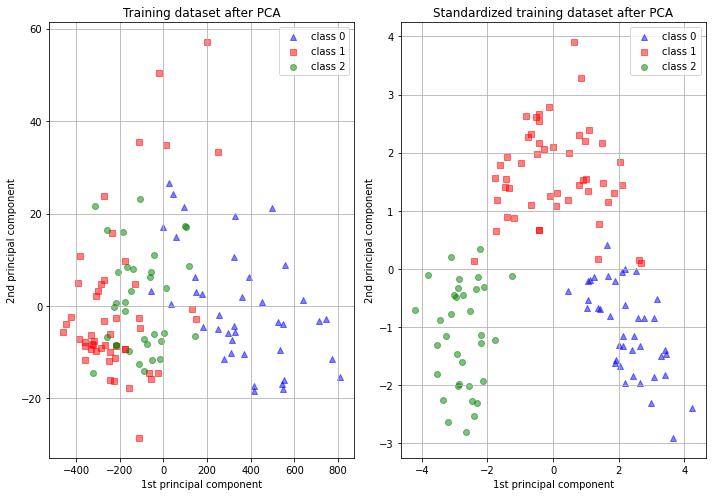

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.pipeline import make_pipeline
print(__doc__)

# Code source: Tyler Lanigan <tylerlanigan@gmail.com>
#              Sebastian Raschka <mail@sebastianraschka.com>

# License: BSD 3 clause

RANDOM_STATE = 42
FIG_SIZE = (10, 7)


features, target = load_wine(return_X_y=True)

# Make a train/test split using 30% test size
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.30,
                                                    random_state=RANDOM_STATE)

# Fit to data and predict using pipelined GNB and PCA.
unscaled_clf = make_pipeline(PCA(n_components=2), GaussianNB())
unscaled_clf.fit(X_train, y_train)
pred_test = unscaled_clf.predict(X_test)

# Fit to data and predict using pipelined scaling, GNB and PCA.
std_clf = make_pipeline(StandardScaler(), PCA(n_components=2), GaussianNB())
std_clf.fit(X_train, y_train)
pred_test_std = std_clf.predict(X_test)

# Show prediction accuracies in scaled and unscaled data.
print('\nPrediction accuracy for the normal test dataset with PCA')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test)))

print('\nPrediction accuracy for the standardized test dataset with PCA')
print('{:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_std)))

# Extract PCA from pipeline
pca = unscaled_clf.named_steps['pca']
pca_std = std_clf.named_steps['pca']

# Show first principal components
print('\nPC 1 without scaling:\n', pca.components_[0])
print('\nPC 1 with scaling:\n', pca_std.components_[0])

# Use PCA without and with scale on X_train data for visualization.
X_train_transformed = pca.transform(X_train)
scaler = std_clf.named_steps['standardscaler']
X_train_std_transformed = pca_std.transform(scaler.transform(X_train))

# visualize standardized vs. untouched dataset with PCA performed
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=FIG_SIZE)


for l, c, m in zip(range(0, 3), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax1.scatter(X_train_transformed[y_train == l, 0],
                X_train_transformed[y_train == l, 1],
                color=c,
                label='class %s' % l,
                alpha=0.5,
                marker=m
                )

for l, c, m in zip(range(0, 3), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax2.scatter(X_train_std_transformed[y_train == l, 0],
                X_train_std_transformed[y_train == l, 1],
                color=c,
                label='class %s' % l,
                alpha=0.5,
                marker=m
                )

ax1.set_title('Training dataset after PCA')
ax2.set_title('Standardized training dataset after PCA')

for ax in (ax1, ax2):
    ax.set_xlabel('1st principal component')
    ax.set_ylabel('2nd principal component')
    ax.legend(loc='upper right')
    ax.grid()

plt.tight_layout()

plt.show()

n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.27s	69510	0.610	0.657	0.633	0.481	0.629	0.129
random   	0.19s	69907	0.633	0.674	0.653	0.518	0.649	0.131
PCA-based	0.03s	70768	0.668	0.695	0.681	0.558	0.678	0.142
__________________________________________________________________________________


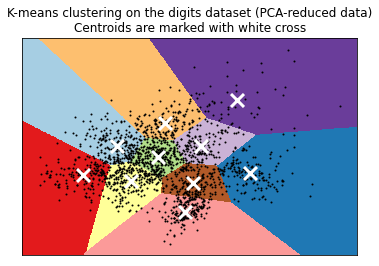

In [2]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

X_digits, y_digits = load_digits(return_X_y=True)
data = scale(X_digits)

n_samples, n_features = data.shape
n_digits = len(np.unique(y_digits))
labels = y_digits

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()